In [23]:
import pandas as pd
import numpy as np
import os
import requests
import yfinance as yf
from fredapi import Fred

# --- Config ---
API_KEY = "YOUR_ALPHA_VANTAGE_API_KEY"  # Replace with your Alpha Vantage key
FRED_API_KEY = "c0fa7dfb37c9b54360f00743a302326c"

data_folder = "data"
os.makedirs(data_folder, exist_ok=True)

# --- Load Existing CSVs ---
files = {
    "bitcoin": "bitcoin.csv",
    "gold": "gold.csv",
    "sp500": "sp500.csv",
    "treasury_3m": "treasury_3m.csv",
    "treasury_10y": "treasury_10y.csv"
}

data = {}
for key, file in files.items():
    path = os.path.join(data_folder, file)
    if os.path.exists(path):
        data[key] = pd.read_csv(path, parse_dates=["timestamp"], index_col="timestamp")
    else:
        print(f"⚠️ {file} not found. Skipping...")

# --- Alpha Vantage Helper ---
def fetch_alpha_vantage_data(url, filename, date_col="date"):
    path = os.path.join(data_folder, filename)
    if os.path.exists(path):
        print(f"{filename} already exists.")
        return pd.read_csv(path, parse_dates=[date_col], index_col=date_col)

    print(f"Fetching {filename}...")
    response = requests.get(url)
    data_json = response.json()

    if "Time Series (Daily)" in data_json:
        series = data_json["Time Series (Daily)"]
        df = pd.DataFrame.from_dict(series, orient="index")
        df.index = pd.to_datetime(df.index)
        df = df.rename(columns=lambda x: x.split(". ")[-1])
        df = df[["close"]].astype(float)
    else:
        raise ValueError("Unexpected data format from Alpha Vantage")

    df.sort_index(inplace=True)
    df.to_csv(path)
    return df

# --- Oil ---
oil_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=WTI&apikey={API_KEY}"
try:
    oil_data = fetch_alpha_vantage_data(oil_url, "oil.csv", date_col="timestamp")
    if "close" in oil_data.columns or "Close" in oil_data.columns:
        close_col = "close" if "close" in oil_data.columns else "Close"
        oil_data.rename(columns={close_col: "oil_price"}, inplace=True)
        data["oil"] = oil_data[["oil_price"]]
    else:
        print("⚠️ No close column found in oil data. Skipping oil.")
except Exception as e:
    print(f"Error fetching oil data: {e}")

# --- Unemployment from FRED ---
print("Downloading unemployment data from FRED...")
fred = Fred(api_key=FRED_API_KEY)
unemployment_df = fred.get_series('UNRATE', observation_start='2000-01-01')
unemployment_df = unemployment_df.to_frame(name='Unemployment')
unemployment_df.index.name = 'Date'
unemployment_df = unemployment_df.resample('D').ffill()
unemployment_df.to_csv("data/unemployment.csv")

# --- Copper Data ---
copper_path = os.path.join(data_folder, "copper.csv")
if not os.path.exists(copper_path):
    print("Downloading copper data...")
    copper_download = yf.download('HG=F', start='2000-01-01', end='2025-01-01')
    copper_download[['Close']].rename(columns={'Close': 'copper_price'}).to_csv(copper_path)

# Clean and load copper.csv
copper_df = pd.read_csv(
    copper_path,
    index_col=0,
    parse_dates=True
)

# Force index to datetime and clean
copper_df.index = pd.to_datetime(copper_df.index, errors="coerce")
copper_df.index.name = "Date"
copper_df = copper_df[~copper_df.index.isna()]
copper_df = copper_df.resample("D").ffill()

# Rename price column
if "Close" in copper_df.columns:
    copper_df.rename(columns={"Close": "Copper"}, inplace=True)
elif "copper_price" in copper_df.columns:
    copper_df.rename(columns={"copper_price": "Copper"}, inplace=True)

# --- Merge All ---
print("Merging all datasets...")
df = data["sp500"][["close"]].rename(columns={"close": "sp500_Close"})

# Add financial indicators
to_add = ["bitcoin", "gold"]
for key in to_add:
    df = df.join(data[key][["Close"]].rename(columns={"Close": f"{key}_Close"}), how="left")

# Add treasury and oil
for key in ["treasury_3m", "treasury_10y"]:
    df = df.join(data[key], how="left")
if "oil" in data:
    df = df.join(data["oil"], how="left")

# Add unemployment and copper
df = df.join(unemployment_df, how="left")
df = df.join(copper_df[["Copper"]], how="left")

# Clean and save
df.dropna(inplace=True)
df.to_csv(os.path.join(data_folder, "merged_data.csv"))
print("✅ Merged data saved to data/merged_data.csv")

oil.csv already exists.
Merging all datasets...
✅ Merged data saved to data/merged_data.csv


/var/folders/tc/qn2wdtrd4n3c7xsgj4x5n6f80000gn/T/ipykernel_12792/1873816221.py:86: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  copper_df = pd.read_csv(
/var/folders/tc/qn2wdtrd4n3c7xsgj4x5n6f80000gn/T/ipykernel_12792/1873816221.py:93: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  copper_df.index = pd.to_datetime(copper_df.index, errors="coerce")


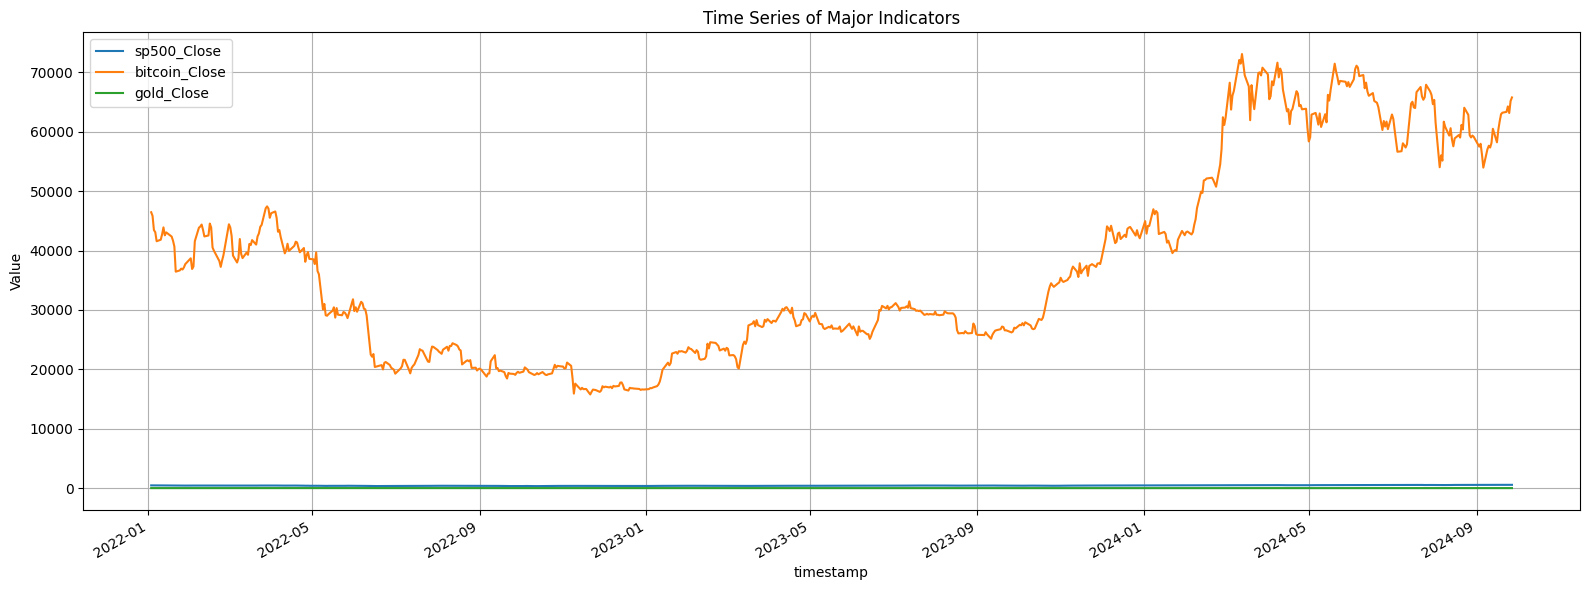

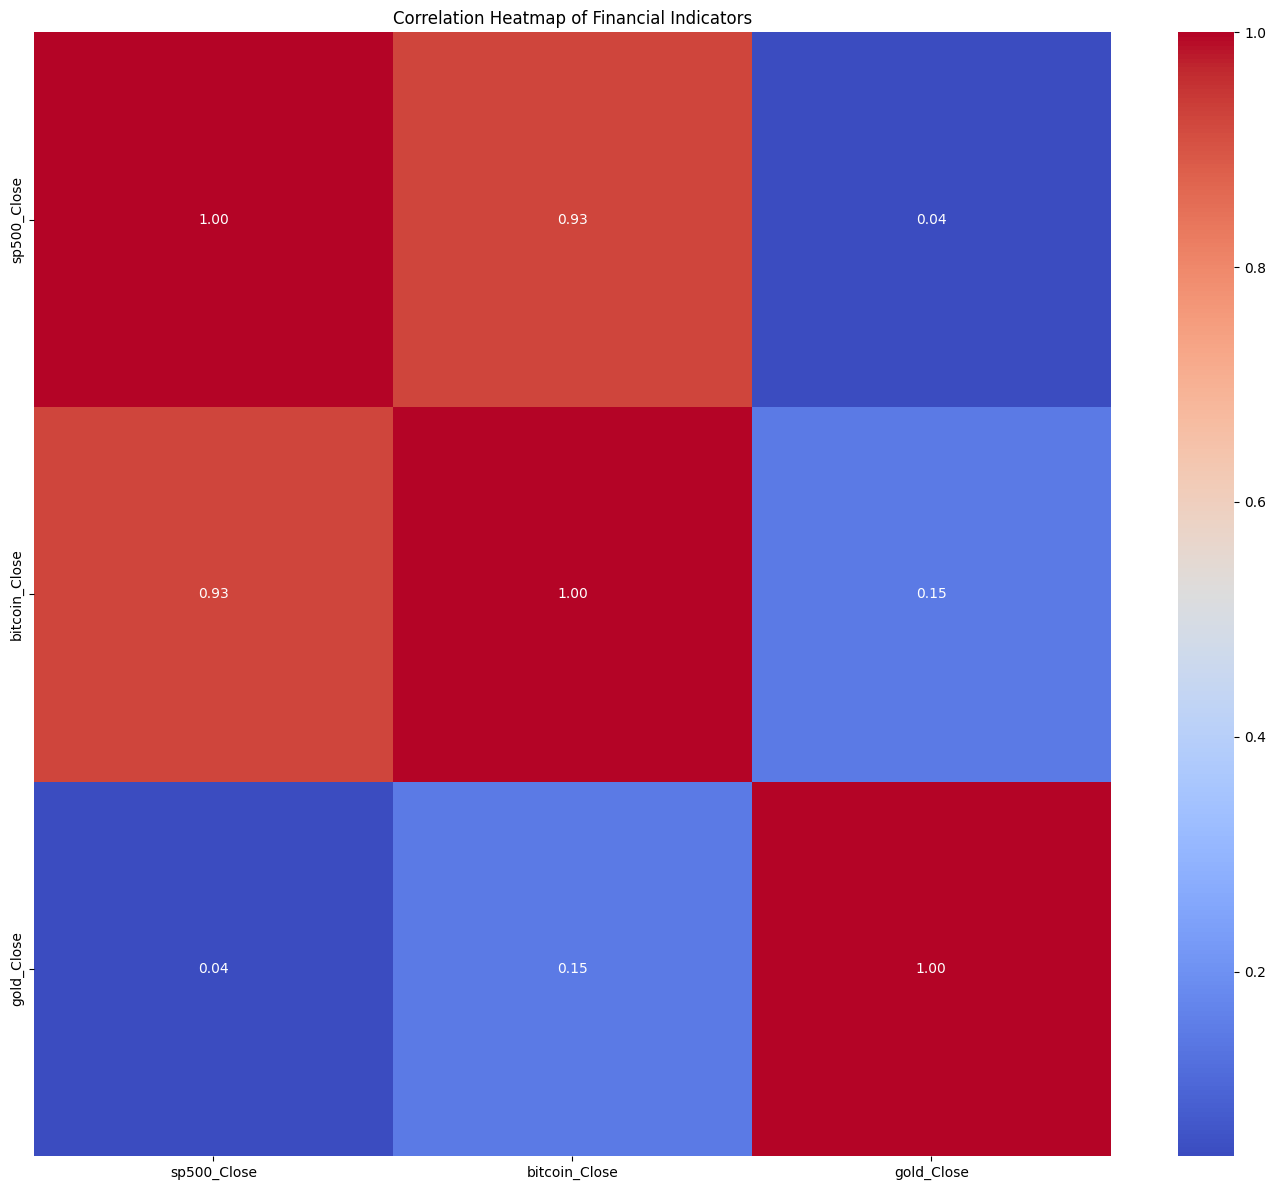

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged dataset
df = pd.read_csv("data/merged_data.csv", parse_dates=["timestamp"], index_col="timestamp")

# Clean and prepare the data
df = df.apply(pd.to_numeric, errors="coerce")
df.dropna(inplace=True)

# --- Plot Time Series of Major Indicators ---
plot_columns = [col for col in [
    "sp500_Close", "bitcoin_Close", "gold_Close", "oil_price", "Unemployment", "Copper"
] if col in df.columns]

df[plot_columns].plot(figsize=(16, 6))
plt.title("Time Series of Major Indicators")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(14, 12))
correlation_matrix = df[plot_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Financial Indicators")
plt.tight_layout()
plt.show()

# --- Oil vs. S&P 500 Plot ---
if "sp500_Close" in df.columns and "oil_price" in df.columns:
    df[["sp500_Close", "oil_price"]].plot(figsize=(14, 6))
    plt.title("S&P 500 vs. Oil Prices")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Rolling Correlation: S&P 500 vs. Oil ---
if "sp500_Close" in df.columns and "oil_price" in df.columns:
    rolling_corr = df["sp500_Close"].rolling(window=30).corr(df["oil_price"])
    rolling_corr.plot(figsize=(14, 5))
    plt.title("30-Day Rolling Correlation: S&P 500 vs. Oil")
    plt.axhline(0, color='gray', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Optional: Copper vs. S&P 500 Plot ---
if "sp500_Close" in df.columns and "Copper" in df.columns:
    df[["sp500_Close", "Copper"]].plot(figsize=(14, 6))
    plt.title("S&P 500 vs. Copper Prices")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Optional: Unemployment vs. S&P 500 ---
if "sp500_Close" in df.columns and "Unemployment" in df.columns:
    df[["sp500_Close", "Unemployment"]].plot(figsize=(14, 6))
    plt.title("S&P 500 vs. Unemployment Rate")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()